In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Original dataset
raw = pd.read_csv("OnlineNewsPopularity.csv")

# Using some webscraping, I went and found some more accurate values for data channel and added dates
channel_update = pd.read_csv("Updated_Data.csv")
channel_update

# Join the two datasets on the urls
data = raw.join(channel_update.set_index('url'), on='url').set_index('url')

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39644 entries, http://mashable.com/2013/01/07/amazon-instant-video-browser/ to http://mashable.com/2014/12/27/youtube-channels-2015/
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   timedelta                       39644 non-null  float64
 1   n_tokens_title                  39644 non-null  float64
 2   n_tokens_content                39644 non-null  float64
 3   n_unique_tokens                 39644 non-null  float64
 4   n_non_stop_words                39644 non-null  float64
 5   n_non_stop_unique_tokens        39644 non-null  float64
 6   num_hrefs                       39644 non-null  float64
 7   num_self_hrefs                  39644 non-null  float64
 8   num_imgs                        39644 non-null  float64
 9   num_videos                      39644 non-null  float64
 10  average_token_length            39644 non-null  floa

Seems good! The only columns with nulls are the ones I added.

# Days of the Week

Not all the `weekday` entries could be found in the webscrape so I replaced the nulls in the `weekday` column with the values from the original dataset, the actual dates will just stay n/a. 

In [3]:
# Renaming the old columns for ease. 
print(data.weekday.unique())

old_label = iter(['weekday_is_monday', 'weekday_is_tuesday','weekday_is_wednesday', 'weekday_is_thursday', 
                  'weekday_is_friday','weekday_is_saturday', 'weekday_is_sunday'])
new_label= ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
label_map = {next(old_label):label for label in new_label}
data = data.rename(columns=label_map)

# replace nulls in 'weekday' with entries from the original dataset
if len(data[data.weekday.isnull()]) != 0 :

    index_of_nulls = list(data[data.weekday.isnull()].index) + list(data[data.weekday=='Null'].index)
    
    days_melt = pd.melt(data.reset_index(),id_vars=['url'],value_vars=new_label,var_name='day of the week')
    days_melt = days_melt[days_melt.value==1]

    for index in index_of_nulls:
        weekday = list(days_melt[days_melt['url'] == index]['day of the week'])
        data.at[index,'weekday'] = weekday[0]

# drop the original columns
for col in new_label:
    if col in data.columns:
        data=data.drop([col], axis=1)
        
print(data.weekday.unique())

# get rid of timedelta
if 'timedelta' in data.columns:
        data=data.drop('timedelta', axis=1)

['Mon' 'Wed' 'Thu' 'Fri' 'Sat' 'Sun' 'Tue' nan]
['Mon' 'Wed' 'Thu' 'Fri' 'Sat' 'Sun' 'Tue']


Perfect! Lets take a look at the `weekday` column

In [4]:
def break_down(column,sort='total articles',show=True):
    counts = data[[column,'shares']].groupby(by=column).count().rename(columns={'shares':'total articles'})
    sums = data[[column,'shares']].groupby(by=column).sum().rename(columns={'shares':'sum shares'})
    group = counts.join(sums,on=column)
    
    # add the shares per article ratio
    group["shares per article ratio"] = group["sum shares"]/group["total articles"]

    # add percentages to make it easier to see
    group['percent of all shares'] = group['sum shares']/group['sum shares'].sum()*100
    group['percent of articles'] = group['total articles']/group['total articles'].sum()*100

    # sort
    group = group.sort_values('total articles',ascending=False)
    
    if show==True:
        group
    
    return group

break_down('weekday')

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
weekday,,,,,
Wed,7535,25210957,3345.846981,18.729382,19.006659
Thu,7325,23079271,3150.753720,17.145739,18.476945
Tue,7227,24361555,3370.908399,18.098356,18.229745
Mon,6353,22110832,3480.376515,16.426279,16.025124
Fri,6021,19923684,3309.032387,14.801433,15.187670
Sat,2738,10837541,3958.196129,8.051279,6.906468
Sun,2445,9082612,3714.769734,6.747531,6.167390


Seems like less articles are published on Saturday and Sunday so I combined both these entries as `weekend`

In [5]:
data['weekday'] = data['weekday'].replace(['Sat','Sun'],'Weekend')
break_down('weekday')         

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
weekday,,,,,
Wed,7535,25210957,3345.846981,18.729382,19.006659
Thu,7325,23079271,3150.753720,17.145739,18.476945
Tue,7227,24361555,3370.908399,18.098356,18.229745
Mon,6353,22110832,3480.376515,16.426279,16.025124
Fri,6021,19923684,3309.032387,14.801433,15.187670
Weekend,5183,19920153,3843.363496,14.798810,13.073857


# Data ChannelsD
Dropped the original data channels columns and made sure to label all the n/a entires as `Unlabeled`.

In [6]:
print(data.data_channel.unique())

# drop columns
uness_col = ['data_channel_is_lifestyle',' data_channel_is_entertainment', 'data_channel_is_bus',
           'data_channel_is_socmed', 'data_channel_is_tech','data_channel_is_world','is_weekend']

for col in uness_col:
    if col in data.columns:
        data=data.drop([col], axis=1)

# make sure any n/a are correctly catergorized as 'Unlabeled'
if len(data[data.data_channel.isnull()]) != 0:
    for index in list(data[data.data_channel.isnull()].index):
        data.at[index,'data_channel'] = 'Unlabeled'

print(data.data_channel.unique())

['Entertainment' 'Business' 'Tech' 'U.S.' 'World' 'Culture' 'Social Good'
 'Unlabeled' nan]
['Entertainment' 'Business' 'Tech' 'U.S.' 'World' 'Culture' 'Social Good'
 'Unlabeled']


In [7]:
break_down('data_channel')

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
data_channel,,,,,
Entertainment,10778,35499929,3293.739933,26.373126,27.186964
World,7616,24084453,3162.349396,17.892495,19.210978
Tech,7261,25210032,3471.977964,18.728695,18.315508
Business,6180,21250001,3438.511489,15.786763,15.588740
Culture,5251,19223772,3660.973529,14.281464,13.245384
Unlabeled,1353,4303431,3180.658537,3.197047,3.412875
U.S.,883,3673081,4159.774632,2.728756,2.227323
Social Good,322,1361753,4229.046584,1.011655,0.812229


The most articles are from the `Entertainment` category, followed by `World` and `Tech`. Understandably the highest sum shares come from the same categories.

Since `Social Good`, `US`, and the unlabeled data channels are so small, I just grouped them up into one category labeled `Other`

In [8]:
data['data_channel'] = data['data_channel'].replace(['Social Good','U.S.','Unlabeled'],'Other')
break_down('data_channel') 

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
data_channel,,,,,
Entertainment,10778,35499929,3293.739933,26.373126,27.186964
World,7616,24084453,3162.349396,17.892495,19.210978
Tech,7261,25210032,3471.977964,18.728695,18.315508
Business,6180,21250001,3438.511489,15.786763,15.588740
Culture,5251,19223772,3660.973529,14.281464,13.245384
Other,2558,9338265,3650.611806,6.937457,6.452427


# Distribution of Shares
Now that the weekdays and channels have been updated, lets look at the shares as a whole

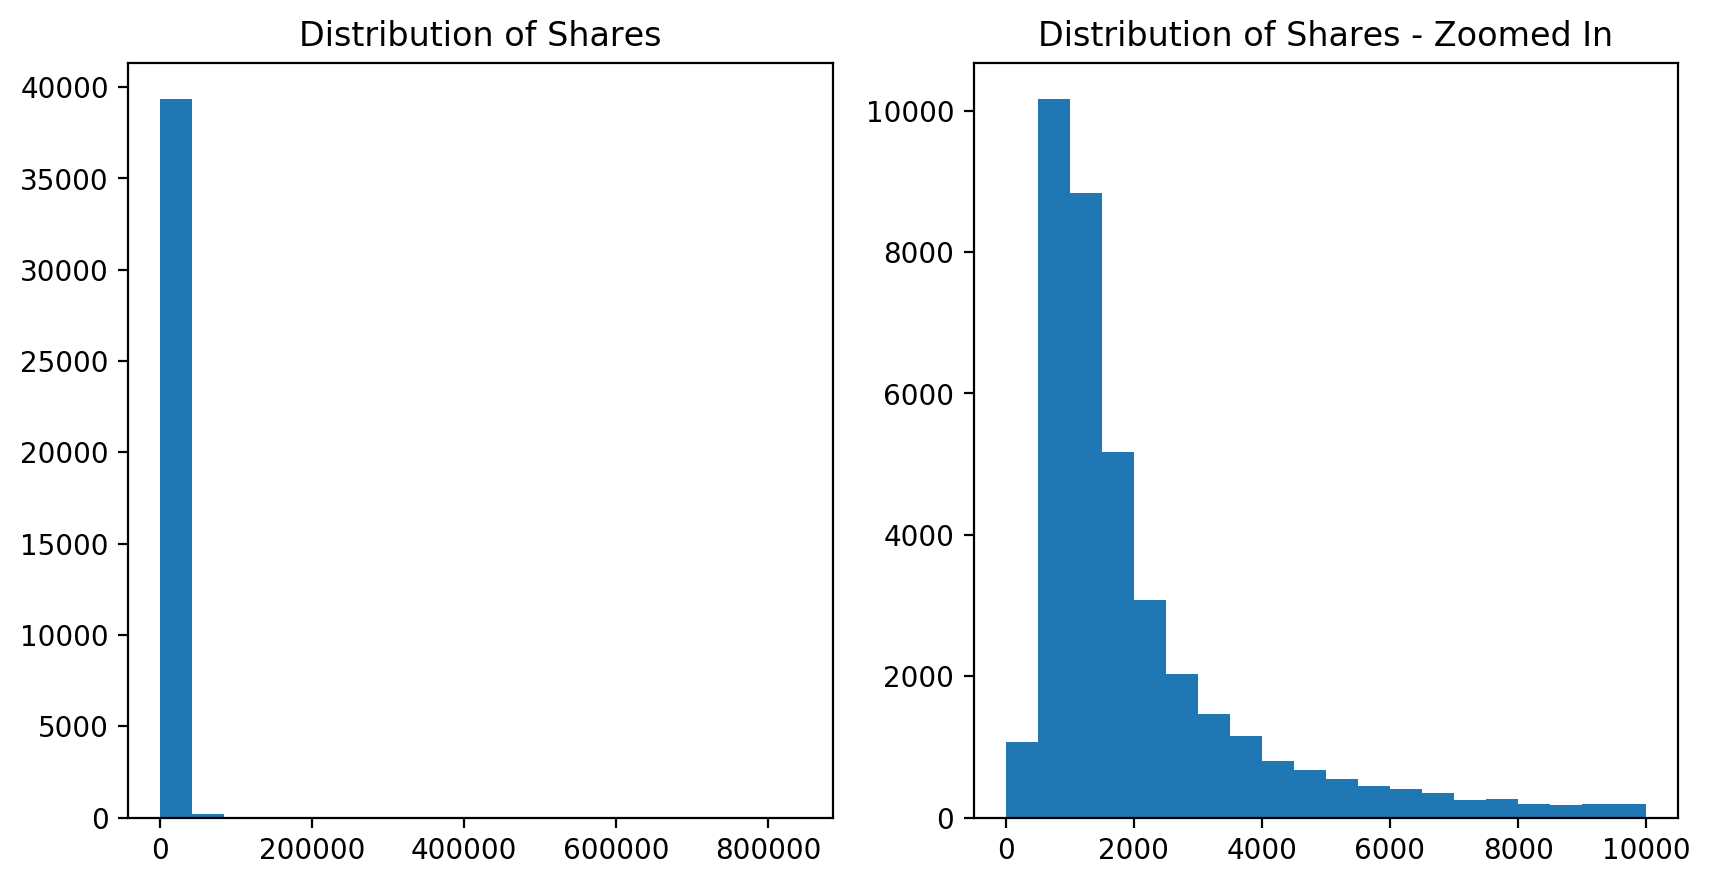

In [9]:
plt.figure(figsize=(10,5),dpi=200)

plt.subplot(121)
plt.hist(data['shares'],bins=20);
plt.title('Distribution of Shares')

plt.subplot(122)
plt.hist(data['shares'],bins=20,range=(0,10000))
plt.title('Distribution of Shares - Zoomed In');

Seems like there's alot of outlires. Viral articles get a whole lot more shares than the typical article

Saved the data in two forms. `OnlineNewsPopularity_Cleaned` holds the data as it currently is, while `OnlineNewsPopularity_ForModeling` uses dummiest to convert the categorical columns into numeric columns for modeling

In [10]:
data.to_csv('OnlineNewsPopularity_Clean.csv')

model_data = pd.get_dummies(data, columns=['data_channel','weekday'])

# drop the dates, we won't need them for modeling
model_data = model_data.drop(columns='date')
model_data.to_csv('OnlineNewsPopularity_ForModeling.csv')

model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39644 entries, http://mashable.com/2013/01/07/amazon-instant-video-browser/ to http://mashable.com/2014/12/27/youtube-channels-2015/
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_tokens_title                39644 non-null  float64
 1   n_tokens_content              39644 non-null  float64
 2   n_unique_tokens               39644 non-null  float64
 3   n_non_stop_words              39644 non-null  float64
 4   n_non_stop_unique_tokens      39644 non-null  float64
 5   num_hrefs                     39644 non-null  float64
 6   num_self_hrefs                39644 non-null  float64
 7   num_imgs                      39644 non-null  float64
 8   num_videos                    39644 non-null  float64
 9   average_token_length          39644 non-null  float64
 10  num_keywords                  39644 non-null  float64
 11  kw_min_min       